# Übung: Semantische Segmentierung von intergranularen Brüchen aus  Bilddaten

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
from fastai.vision.all import * 
import fastai
import torch
print("sys.version", sys.version)
print("cuda device name(0)", torch.cuda.get_device_name(0))
print("torch.__version__", torch.__version__)
print("fastai.__version__", fastai.__version__)

sys.version 3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]
cuda device name(0) Tesla V100S-PCIE-32GB
torch.__version__ 1.7.1
fastai.__version__ 2.5.3


In [3]:
import pathlib
path = Path('./volumes')

## Datensatz laden

In [4]:
from PIL import Image
import numpy

def get_tif_images(file_path):
    files = get_image_files( file_path )
    files =  [file for file in files if "_BSE_" in str(file)]
    return files

def load_multislice_tif(file_path, max_slices):
    image = Image.open(file_path)
    h,w = numpy.shape( image )
    n_frames = image.n_frames
    if n_frames>max_slices:
        n_frames = max_slices
    imagelist = [] 
    for i in range(n_frames):
        image.seek(i)
        imagelist.append( PILImage.create( numpy.array( image ) ) )
    return imagelist; 

def int2float(o:TensorImage):
    # print("executing int2float")
    o = o * 255.0
    return o.float()

class MultiSliceImage():
    def __init__(self, data):
        self.data = data
   
    @classmethod
    def create_multi( cls, file_path):
        return cls( load_multislice_tif(file_path, 256) )
    
    @classmethod
    def create_single( cls, file_path):
        return cls( load_multislice_tif(file_path, 1) )
        
def MultiSliceImageBlock(): 
    return TransformBlock(type_tfms  = MultiSliceImage.create_single,
                          batch_tfms = int2float) 

def MultiSliceMaskBlock(): 
    return TransformBlock(type_tfms  = MultiSliceImage.create_multi) 
       
def get_x( filename ):
    filename_parts = str(filename.stem).split("_")
    y = path / Path( "_".join(filename_parts[:-2]) + "_GT_" + filename_parts[-1] + ".tif" )
    return y

def get_y( filename ):
    return filename

In [5]:
import traceback

class SequenceTfms(Transform):
    def __init__(self, tfms): 
        self.tfms = tfms
        
    def encodes(self, x: MultiSliceImage):
        try:
            for transform in self.tfms:
                if len(x.data) > 1:
                    transform.before_call( x.data[0], None )
                for i in range(len(x.data)):
                    x.data[i] = transform.encodes( x.data[i] )
        except Exception:
            print(traceback.format_exc())   
        return x

In [6]:
from torchvision import transforms

datablock = DataBlock(
    blocks     = ( MultiSliceMaskBlock, MultiSliceImageBlock ),
    get_items  = get_tif_images, 
    get_x      = get_x,
    get_y      = get_y,
    splitter   = RandomSplitter(),
    item_tfms  = SequenceTfms( [ RandomCrop(256) ] ),
    batch_tfms = SequenceTfms( [ Rotate(max_deg=360) ] )
)

def create_batch(data):
    try:
        x,y = data[0]
        x = torch.cat( [transforms.ToTensor()(image) for image in x.data] )       
        x = torch.unsqueeze( x, dim=0 )       
        x = torch.unsqueeze( x, dim=0 )       
        y = transforms.ToTensor()(y.data[0])
        y = torch.unsqueeze( y, dim=0 )        
        y = torch.unsqueeze( y, dim=0 )        
        y = TensorImage(y)
        return TensorMask(x),TensorImage(y)
    except Exception as err:
        traceback.print_tb(err.__traceback__)
        
data_loader = datablock.dataloaders(source = path, bs=1, create_batch=create_batch)

y-batch TensorImage([[112., 115., 137.,  ..., 117., 161., 123.],
        [117., 106., 139.,  ..., 159., 142., 131.],
        [106., 128., 123.,  ..., 159., 128., 164.],
        ...,
        [ 65.,  90.,  54.,  ...,  46.,  57.,  46.],
        [ 63.,  65.,  79.,  ...,  87.,  46.,  60.],
        [ 79.,  43., 101.,  ...,  49.,  43.,  30.]])


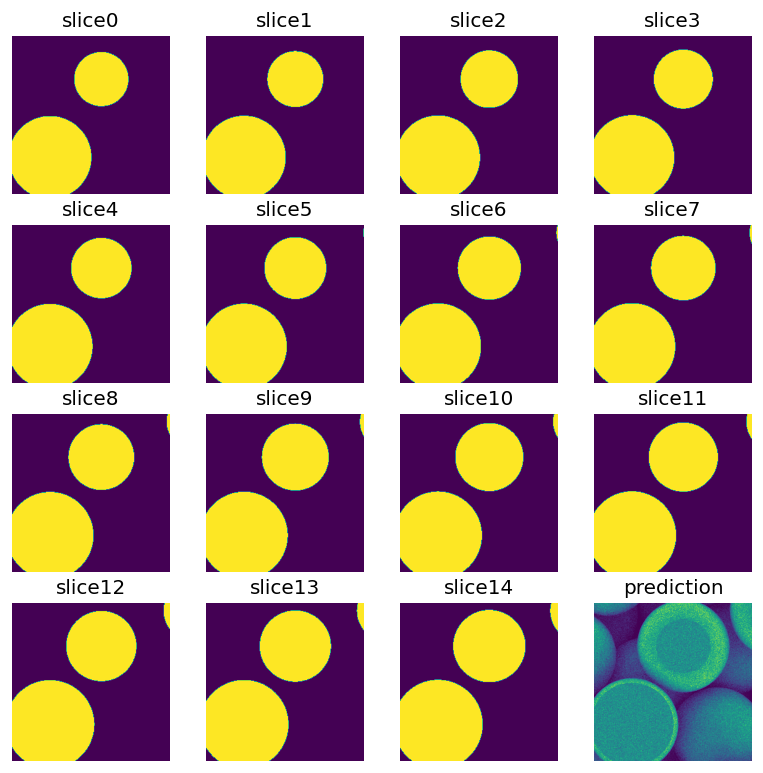

In [7]:
from display import show_sequence_batch

show_sequence_batch(data_loader)            

## Netzwerk Modell

In [8]:
def build_conv_block( in_features, mid_features, out_features, kernel_size, conv_per_block ):
    layers = []
    for i in range(conv_per_block):
        in_f = mid_features
        if i == 0:
            in_f = in_features
        out_f = mid_features
        if i == conv_per_block-1:
            out_f = out_features
        _, kernel_x, kernel_y = kernel_size
        pad = (0,int(kernel_x/2),int(kernel_y/2))
        layers.append( ("Conv"+str(i), nn.Conv3d(in_f,out_f,kernel_size,padding=pad,padding_mode='replicate') ) )
        layers.append( ("ReLU"+str(i), nn.ReLU() ) )
    return torch.nn.Sequential( OrderedDict( layers ) )    

def required_input_size_z( layer_depth, kernel_size ):
    (kernel_size_z,_,_) = kernel_size
    if layer_depth == 0:
        return kernel_size_z
    return required_input_size_z( layer_depth-1, kernel_size ) + int( kernel_size_z / 2 )

def max_depth( input_size, kernel_size, conv_per_block, depth = 0 ):
    kernel_z,kernel_y,kernel_x = kernel_size
    input_z,input_y,input_x = input_size
    if kernel_z > input_z:
        print("maximum depth of depth exceeded for input size ", input_size )
        return depth-1
    pad_loss_z,pad_loss_y,pad_loss_x = (int(kernel_z/2)*conv_per_block,int(kernel_y/2)*conv_per_block,int(kernel_x/2)*conv_per_block)
    input_size = (int(input_z/2)-pad_loss_z,int(input_y/2)-pad_loss_y,int(input_x/2)-pad_loss_x )
    print("input",input_size, "depth", depth )
    return max_depth( input_size, kernel_size, depth+1)    

class EncoderBlock(torch.nn.Module):
    def __init__(self, layer_depth, in_features, mid_features, out_features, kernel_size, conv_per_block, debug=False ):
        super().__init__()
        self.layer_depth = layer_depth
        self.kernel_size = kernel_size
        self.debug = debug
        self.conv_layers = build_conv_block( in_features, mid_features, out_features, kernel_size, conv_per_block )
        self.pool  = torch.nn.MaxPool3d(2)
    
    def forward(self, x):
        hr_values = torch.clone(x)
        if self.debug:
            print("Encoder            from", x.shape)
        input_size = required_input_size_z( self.layer_depth, self.kernel_size )
        hr_values = hr_values[:,:,0:input_size,:,:]
        if self.debug:
            print("                     ", hr_values.shape, "after discarding")
        x = self.conv_layers(x)
        if self.debug:
            print("                     ", x.shape, "after conv")
        x = self.pool(x)
        if self.debug:
            print("                     ", x.shape, "after pool")
            print("encoding to ", x.shape, "high_res", hr_values.shape)
        return x, hr_values

class DecoderBlock(torch.nn.Module):
    def __init__(self, layer_depth, in_features, mid_features, out_features, kernel_size, conv_per_block, debug=False ):
        super().__init__()
        self.layer_depth = layer_depth
        self.kernel_size = kernel_size
        self.debug = debug
        self.upsampling = torch.nn.Upsample(scale_factor=2 )
        self.conv_layers = build_conv_block( in_features, mid_features, out_features, kernel_size, conv_per_block )
    
    def forward(self, x, hr_values):
        if self.debug:
            print("Decoder (depth ",self.layer_depth,") upsampling from", x.shape)
        x = self.upsampling(x)
        if self.debug:
            print("                   to", x.shape)
        input_size = required_input_size_z( self.layer_depth, self.kernel_size )
        x = x[:,:,0:input_size,:,:]
        if self.debug:
            print("                     ", x.shape, "after discarding")
            print("decoding upsamples to", x.shape, "high_res", hr_values.shape)        
        x = torch.cat( (x,hr_values), 1 )
        x = self.conv_layers(x)
        if self.debug:
            print("                     ", x.shape, "after conv")
        return x
    
class MonteCarloNet(torch.nn.Module):
    def __init__(self, n_features = 16, kernel_size = (3,3,3), conv_per_block = 1, debug=False):
        super().__init__()
        self.n_features = n_features
        self.kernel_size = kernel_size
        self.conv_per_block = conv_per_block
        self.debug = debug
        
        max_d = max_depth( (256,256,256),kernel_size,conv_per_block )
        print("Constructing MonteCarloNet of depth", max_d)
        
        encoders = []
        decoders = []
        
        encoders.append( ( "Encoder0", EncoderBlock(0, 1,n_features,n_features,kernel_size,conv_per_block, debug ) ) )
        decoders.append( ( "Decoder0", DecoderBlock(0, n_features+1,n_features,1,kernel_size,conv_per_block, debug ) ) )
        
        for i in range( 1, max_d ):
            encoders.append( ( "Encoder" + str(i), EncoderBlock(i, n_features,n_features,n_features,kernel_size,conv_per_block, debug ) ) )
            decoders.append( ( "Decoder" + str(i), DecoderBlock(i, 2*n_features,n_features,n_features,kernel_size,conv_per_block, debug ) ) )
                
        decoders.reverse()
                
        self.encoder_blocks = torch.nn.Sequential( OrderedDict( encoders ) )
        self.decoder_blocks = torch.nn.Sequential( OrderedDict( decoders ) )

    def forward(self, x):
        values  = []
        for encoder in self.encoder_blocks:
            x, hr_values = encoder( x )
            values.append( hr_values )
            
        values.reverse()
            
        for i, decoder in enumerate( self.decoder_blocks ):
            highres_values = values[i]
            x = decoder( x, highres_values )

        # print("forward output", x.shape)
        # output = x[:,:,0,:,:]
        # print("forward output", output[0][0][0].cpu())
        return x[:,:,0,:,:]       

    def name(self):
        return "MCNet_width_" + str(self.n_features) + "_depth_" + str(14*self.conv_per_block) + "_kernel_" + str(self.kernel_size)

In [9]:
class ImageAndMaskMSELoss(nn.L1Loss):
    def __init__(self, size_average=None, reduce=None, reduction='mean'):
        super(ImageAndMaskMSELoss, self).__init__(size_average, reduce, reduction)

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        input = TensorBase(input)
        target = target.squeeze(0)
        target = TensorBase(target)
        # print("loss function input", input.shape, input)
        # print("loss function target", target.shape, target)
        return super(ImageAndMaskMSELoss,self).forward(input, target)

In [10]:
# learner.lr_find()

In [11]:
gewaehlteLernrate = 0.0001

In [12]:
from torchinfo import summary
from display import show_preds

for n_features in [4]: # 32,16,8,
    for kernel_size in [(5,3,3)]: # ,(5,3,3),(3,3,3)
        for conv_per_block in [1]: # ,2
            model = MonteCarloNet( n_features, kernel_size, conv_per_block, debug=False )            
            print( model.name() )
            print( summary(model, input_size=(1, 1, 128, 128, 128), device="cpu") )
            learner = Learner( data_loader, model, ImageAndMaskMSELoss() )
            # print( learner.summary() )
            # learner.fit_one_cycle(50, gewaehlteLernrate, cbs=[ShowGraphCallback()])
            learner.load( model.name() + "_50_epochs")
            
            preds,targs = learner.get_preds()     
            show_preds(preds,targs, filename = 'results/' + model.name() + '_100_epochs.png')
            
            learner.recorder.plot_loss()
            plt.savefig( 'results/' + model.name() + '_loss_plot.png')

input (126, 127, 127) depth 0
input (61, 62, 62) depth 0
input (28, 30, 30) depth 0
input (12, 14, 14) depth 0
input (4, 6, 6) depth 0
maximum depth of depth exceeded for input size  (4, 6, 6)
Constructing MonteCarloNet of depth -1
MCNet_width_4_depth_14_kernel_(5, 3, 3)
Layer (type:depth-idx)                   Output Shape              Param #
MonteCarloNet                            --                        --
├─Sequential: 1                          --                        --
│    └─EncoderBlock: 2-1                 [1, 4, 62, 64, 64]        --
│    │    └─Sequential: 3-1              [1, 4, 124, 128, 128]     184
│    │    └─MaxPool3d: 3-2               [1, 4, 62, 64, 64]        --
├─Sequential: 1                          --                        --
│    └─DecoderBlock: 2-2                 [1, 1, 1, 128, 128]       --
│    │    └─Upsample: 3-3                [1, 4, 124, 128, 128]     --
│    │    └─Sequential: 3-4              [1, 1, 1, 128, 128]       226
Total params: 410
Tra

FileNotFoundError: [Errno 2] No such file or directory: 'models/MCNet_width_4_depth_14_kernel_(5, 3, 3)_50_epochs.pth'